## Import necessary packages (run once upon startup)

In [205]:
from __future__ import division 
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline


from skimage.transform import resize
from skimage.morphology import skeletonize
from scipy.signal import resample, savgol_filter, butter, filtfilt
from PIL import Image, ImageDraw
import cv2

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Custom function definitions (run once upon startup)

In [240]:
# Creating directory for analyzed images 
if os.path.isdir("C:/Users/Paul/Desktop/analyzed_images") is False:
    os.mkdir("C:/Users/Paul/Desktop/analyzed_images")

# Intersection over union (IoU), a measure of labelling accuracy (sometimes also called Jaccard score)
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

# Function to detect mouse clicks for the purpose of image calibration
def mclick(event, x, y, flags, param):
    # grab references to the global variables
    global mlocs

    # if the left mouse button was clicked, record the (x, y) coordinates
    if event == cv2.EVENT_LBUTTONDOWN:
        mlocs.append(y)
        

In [241]:
# IMPORT THE TRAINED MODEL

model_apo = load_model("model-acsa-512+32-RF.h5", custom_objects={'IoU': IoU})

## Import Image that you want to analyse (set location under 'image_add')

In [262]:
# Define the image to analyse here and load it
image_add = ("apo_image_csa_RF/insert_images/rf_200.tif")

filename = os.path.splitext(os.path.basename(image_add))[0]
img = load_img(image_add, color_mode='grayscale')
img_copy = img
img = img_to_array(img)
h = img.shape[0]
w = img.shape[1]
img = np.reshape(img,[-1, h, w, 1])
img = resize(img, (1, 512, 512, 1), mode = 'constant', preserve_range = True)
img = img/255.0
img2 = img
# calibDist = []

In [263]:
# OPTIONAL
# Calibrate the analysis by clicking on 2 points in the image, followed by the 'q' key. These two points should be 1cm apart
# Alternatively, change the spacing setting below
# NOTE: Here we assume that the points are spaced apart in the y/vertical direction of the image
img2 = np.uint8(img_copy)
spacing = 10.0 # Space between the two calibration markers (mm)
mlocs = []

# display the image and wait for a keypress
cv2.imshow("image", img2)
cv2.setMouseCallback("image", mclick)
key = cv2.waitKey(0)
 
# if the 'q' key is pressed, break from the loop
if key == ord("q"):
    cv2.destroyAllWindows()

calibDist = np.abs(mlocs[0] - mlocs[1])
print(str(spacing) + ' mm corresponds to ' + str(calibDist) + ' pixels')

IndexError: list index out of range

## Automatic image scaling using hough-transformation

In [273]:
def plot_image(image):
    img = image
    fig, (ax1)= plt.subplots(1, 1, figsize = (15, 15))
    ax1.imshow(img, cmap = "gray")
    ax1.grid(False)
    plt.savefig("Ridge_test_1.tif")
    
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    #channel_count = img.shape[2]
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_the_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) # Creating empty image to draw lines on 

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(blank_image, (x1,y1), (x2,y2), (0, 255, 0), thickness=1)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0) # Overlay image with lines on original images (only needed for plotting)
    return img

image = cv2.imread("apo_image_csa_RF/insert_images/RF_200.tif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Transform BGR Image to RGB
height = image.shape[0]
width = image.shape[1]
# Define ROI with scaling lines
region_of_interest_vertices = [ 
    (150, height),
    (150, 80),
    (1100, 80),
    (1100, height)
]
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # Transform RGB to greyscale for edge detection
canny_image = cv2.Canny(gray_image, 400, 600) # Edge detecition
cropped_image = region_of_interest(canny_image,
                np.array([region_of_interest_vertices], np.int32),) 

# For RF
lines = cv2.HoughLinesP(cropped_image,
                        rho=1,
                        theta=np.pi/180,
                        threshold=50,
                        lines=np.array([]),
                        minLineLength=400,
                        maxLineGap=1)
image_with_lines = draw_the_lines(image, lines)
"""

# For VL 

lines = cv2.HoughLinesP(cropped_image,
                        rho=1, # Distance of pixels in accumulator
                        theta=np.pi/180, # Angle resolution in accumulator
                        threshold=50, # Only only those lines rutrnes that have higher vote value
                        lines=np.array([]),
                        minLineLength=200,
                        maxLineGap=3) # Gap between lines
image_with_lines = draw_the_lines(image, lines)
"""

# Calculate length of the scaling line
scalingline = lines[0][0]
point1 = [scalingline[0], scalingline[1]]
point2 = [scalingline[2], scalingline[3]]
scalingline_length = math.sqrt(((point1[0]-point2[0])**2)
                               +((point1[1]-point2[1])**2))
print(scalingline_length)
#plot_image(image_with_lines)

430.0


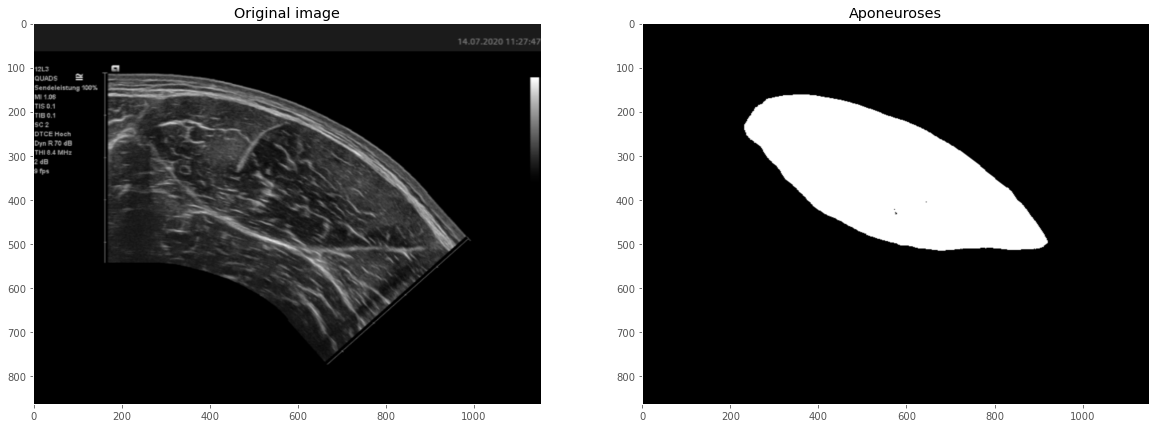

In [265]:
# Get NN predictions for the image

apo_threshold = 0.5 # Set threshold with minimal confidence to make binary 
pred_apo = model_apo.predict(img)
pred_apo_t = (pred_apo > apo_threshold).astype(np.uint8) # SET APO THRESHOLD -> makes binary, unisned integer between 0 and 255 = np.uint8

img = resize(img, (1, h, w, 1))
img = np.reshape(img, (h, w))
pred_apo = resize(pred_apo, (1, h, w,1))
pred_apo = np.reshape(pred_apo, (h, w))
pred_apo_t = resize(pred_apo_t, (1, h, w,1))
pred_apo_t = np.reshape(pred_apo_t, (h, w))

# Uncomment these lines if you want to see the initial predictions
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1) #Fist is n rows in grid, second n columns, third is position
ax1.imshow(img.squeeze(),cmap='gray')
ax1.grid(False)
ax1.set_title('Original image')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(pred_apo_t.squeeze(),cmap="gray")
ax2.grid(False)
ax2.set_title('Aponeuroses')
plt.savefig("C:/Users/Paul/Desktop/analyzed_images/"+filename)


## Caclulate muscle area 

In [280]:
depth = 4.5 # US scanning depth

pix_per_cm = scalingline_length / depth
pred_muscle_area = cv2.countNonZero(pred_apo_t) / pix_per_cm**2

print(pred_muscle_area)

15.755573282855599


In [ ]:
# fig = plt.figure(figsize=(12,12)) # ORIGINAL IMAGE
# plt.imshow(img.squeeze(), cmap='gray')
# plt.title('Original image')
# plt.grid(False)

# fig = plt.figure(figsize=(12,12)) # APO PREDICTIONS
# plt.imshow(pred_apo_t.squeeze(), cmap='gray')
# # plt.title('Aponeurosis predictions')
# plt.grid(False)
# frame1 = plt.gca()
# frame1.axes.get_xaxis().set_visible(False)
# frame1.axes.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(12,12)) # FASC PREDICTIONS
#plt.imshow(pred_fasc_t.squeeze(), cmap='gray')
# plt.title('Fascicle predictions')
plt.grid(False)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)